In [1]:
#!pip install scikit-image
#!pip install opencv-python

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import morphology, io
from skimage.transform import rescale, resize, downscale_local_mean

import os

from skimage.segmentation import slic, mark_boundaries
from skimage import feature #for feature extraction

import cv2

import math
from skimage import transform

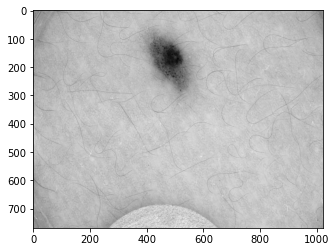

In [3]:
images = os.listdir('../data/interim/resized_images')
segments = os.listdir('../data/interim/resized_segments')
#Greyscaling
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

im = plt.imread('../data/interim/resized_images/'+images[4])
mask = plt.imread('../data/interim/resized_segments/'+segments[4])

gray = rgb2gray(im)
plt.imshow(gray,cmap='gray')

# Calculating features

5.200467010339102 %


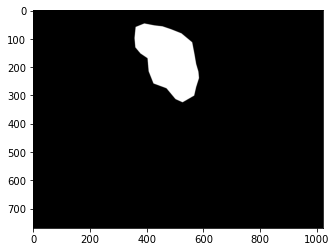

In [4]:
### Area of lesion using segment
# Total size of the image
total = mask.shape[0] * mask.shape[1] 

# Size of mask only
area = np.sum(mask)

# As percentage
print(area/total*100, "%")

plt.imshow(mask, cmap='gray')

40898.137
39403
1495.1371


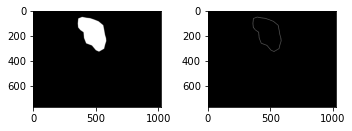

In [5]:
### Calculation perimeter using a brush

## Structural element, that we will use as a "brush" on our mask. The parameter is "brush size"
brush = morphology.disk(3)

# Use this "brush" to erode the image - eat away at the borders

mask_eroded = morphology.binary_erosion(mask, brush)

# Show side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify the new mask is smaller
new_area = np.sum(mask_eroded)

print(area)
print(new_area)

## As the new area is smaller, the perimeter is calculated by subtracting the og mask from the mask_eroded
# Subtract the two masks from each other to get the border/perimeter
# What is the length of this perimeter = how many 1s? 

image_perimeter = mask - mask_eroded
perimeter = np.sum(image_perimeter)
print(perimeter)

plt.imshow(image_perimeter, cmap='gray')


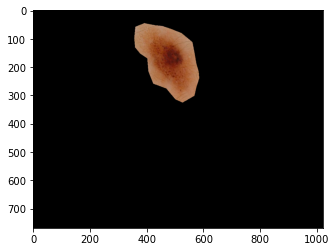

In [6]:
### Creating a version showing the lesion on top of the mask

img1 = im.copy()
img1[mask==0] = 0

plt.imshow(img1)

In [7]:
## We can make a zoomed in version using the mask later if this code is too complicated (also, plagarism?)

# https://stackoverflow.com/questions/59191179/finding-coordinates-of-corners-of-the-maskrectengular-shape-from-mask-matrixb

array = mask.copy()
H,W = array.shape

left_edges = np.where(array.any(axis=1),array.argmax(axis=1),W+1)
flip_lr = cv2.flip(array,1) #1 horz vert 0
right_edges = W - np.where(flip_lr.any(axis=1),flip_lr.argmax(axis=1),W+1)
top_edges = np.where(array.any(axis=0),array.argmax(axis=0),H+1)
flip_ud = cv2.flip(array,0) #1 horz vert 0
bottom_edges = H - np.where(flip_ud.any(axis=0),flip_ud.argmax(axis=0),H+1)

leftmost = left_edges.min()
rightmost = right_edges.max()
topmost = top_edges.min()
bottommost = bottom_edges.max()

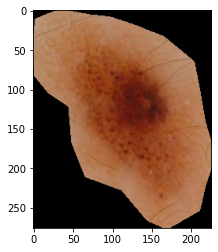

In [8]:
im2 = img1[topmost:bottommost,leftmost:rightmost,:]
mask2 = mask[topmost:bottommost,leftmost:rightmost]
plt.imshow(im2)

0.16601852


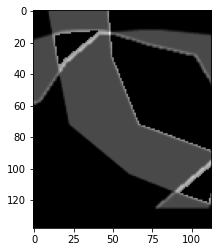

In [9]:
### Asymmetry
## if rotated lesion and lesion are overlapped and there exists a high value of gray, then the lesion is assymetric

#mask2 = morphology.disk(5)

h, w = map(int, mask2.shape)
left = mask2[0:, 0:math.floor(w/2)]
right = mask2[0:, math.ceil(w/2):]
rot_im = transform.rotate(right, 180) ##check if it rotates clockwise or counter clockwise
new_im = rot_im + left
new_im[new_im == 2] = 0

h2, w2 = map(int, new_im.shape)
top = new_im[0: math.floor(h2/2), 0:]
bottom = new_im[math.ceil(h2/2):, 0:]
rot_im2 = transform.rotate(top, 270)
new_im2 = rot_im2 + bottom
new_im2[new_im2 == 2] = 0

plt.imshow(new_im2, cmap='gray')
asymmetry = np.sum(new_im2)/(area)
print(asymmetry)

# number of grey pixels depends on the size of the lesion as well
# so even if the lesion is small, it would still have a lot of gray pixels
# so how would this work as a feature?

In [10]:
### Measuring shape with area and perimeter
## Compactness = l^2/(4pi*A) --> l = perimeter, A = area

c = (perimeter)**2/(4*math.pi*area)
print(c)

## the minimal the value of c (aka the close it is to 1), the more symmetric (circular) it is
# cannot be 1 perfectly due to pixels

# how is compactness different from symmetry
## why check assymetry? a hexagon is pretty symmetrical

4.349593200192389


In [11]:
### Measuring "average" color

# average luminance --> ?
# grayscale image and calculate average --> but what does this tell us? how is this feature valuable?

#calculating color features
colors_of_lesion = im2[mask2==1]
x_R, x_G, x_B = np.mean(colors_of_lesion, axis = 0)
print(x_R, x_G, x_B)

avg_color = (x_R + x_G + x_B)/3
print(avg_color)

164.64489011948416 98.9391354236823 62.51637606325925
108.70013386880858


In [12]:
Perimeter = []
Area = []
Avg_color = []
Compactness = []
Asymmetry = []
Asymmetry_02 = []
Red = []
Green = []
Blue = []

for i in range(len(images)):
    im = plt.imread('../data/interim/resized_images/'+images[i])
    mask = plt.imread('../data/interim/resized_segments/'+segments[i])
    
    mask[0:3,:], mask[-4:-1,:], mask[:,0:3], mask[:,-4:-1] = 0,0,0,0
    
    total = mask.shape[0] * mask.shape[1] 
    area = np.sum(mask)
    
    brush = morphology.disk(3)
    
    mask_eroded = morphology.binary_erosion(mask, brush)
    
    image_perimeter = mask - mask_eroded
    perimeter = np.sum(image_perimeter)
    
    img1 = im.copy()
    img1[mask==0] = 0
    
    c = (perimeter)**2/(4*math.pi*area)
    
    array = mask.copy()
    H,W = array.shape

    left_edges = np.where(array.any(axis=1),array.argmax(axis=1),W+1)
    flip_lr = cv2.flip(array,1)
    right_edges = W - np.where(flip_lr.any(axis=1),flip_lr.argmax(axis=1),W+1)
    top_edges = np.where(array.any(axis=0),array.argmax(axis=0),H+1)
    flip_ud = cv2.flip(array,0)
    bottom_edges = H - np.where(flip_ud.any(axis=0),flip_ud.argmax(axis=0),H+1)

    leftmost = left_edges.min()
    rightmost = right_edges.max()
    topmost = top_edges.min()
    bottommost = bottom_edges.max()
    
    im2 = img1[topmost:bottommost,leftmost:rightmost,:]
    mask2 = mask[topmost:bottommost,leftmost:rightmost]

    h, w = map(int, mask2.shape)
    left = mask2[0:, 0:math.floor(w/2)]
    right = mask2[0:, math.ceil(w/2):]
    rot_im = transform.rotate(right, 180)
    new_im = rot_im + left
    new_im[new_im == 2] = 0

    h2, w2 = map(int, new_im.shape)
    top = new_im[0: math.floor(h2/2), 0:]
    bottom = new_im[math.ceil(h2/2):, 0:]
    rot_im2 = transform.rotate(top, 270)
    new_im2 = rot_im2 + bottom
    new_im2[new_im2 == 2] = 0
    
    asymmetry = np.sum(new_im2)/area
    
    asymmetry_02 = np.sum(new_im2)/(area/4)

    colors_of_lesion = im2[mask2==1]
    x_R, x_G, x_B = np.mean(colors_of_lesion, axis = 0)

    avg_color = (x_R + x_G + x_B)/3
    
    Perimeter.append(perimeter)
    Area.append(area)
    Avg_color.append(avg_color)
    Compactness.append(c)
    Red.append(x_R)
    Green.append(x_G)
    Blue.append(x_B)
    Asymmetry.append(asymmetry)
    Asymmetry_02.append(asymmetry_02)

In [13]:
features = pd.read_csv("../data/raw/example_ground_truth.csv")
features["Perimeter"] = Perimeter
features["Area"] = Area
features["Compactness"] = Compactness
features["Asymmetry"] = Asymmetry
features["Asymmetry*4"] = Asymmetry_02
features["Red"] = Red
features["Green"] = Green
features["Blue"] = Blue
features["Average Color"] = Avg_color
features

,image_id,melanoma,seborrheic_keratosis,Perimeter,Area,Compactness,Asymmetry,Asymmetry*4,Red,Green,Blue,Average Color
0,ISIC_0001769,0.0,0.0,1402.898071,27884.892578,5.616599,0.122560,0.490241,161.351912,98.294626,66.663295,108.769944
1,ISIC_0001852,0.0,0.0,996.160828,16833.162109,4.691194,0.100218,0.400873,114.963288,52.560685,31.287556,66.270510
2,ISIC_0001871,0.0,0.0,1254.980469,26459.980469,4.736686,0.058552,0.234209,182.040832,134.189761,101.775074,139.335222
3,ISIC_0003462,0.0,0.0,993.333435,20858.333984,3.764442,0.059278,0.237112,165.370006,115.710884,86.316572,122.465820
4,ISIC_0003539,0.0,0.0,1495.137085,40898.136719,4.349593,0.166019,0.664074,164.644890,98.939135,62.516376,108.700134
...,...,...,...,...,...,...,...,...,...,...,...,...
145,ISIC_0015443,0.0,0.0,4156.439941,263479.437500,5.217788,0.055674,0.222696,139.181381,88.823654,63.304189,97.103075
146,ISIC_0015445,0.0,0.0,6325.360352,320153.343750,9.944951,0.319881,1.279523,154.078611,91.296768,81.865209,109.080196
147,ISIC_0015483,0.0,0.0,3910.349609,234266.328125,5.194114,0.049988,0.199951,141.942669,105.463502,91.910759,113.105644
148,ISIC_0015496,0.0,0.0,4048.489990,236060.453125,5.525264,0.041352,0.165406,171.707669,97.844357,76.946408,115.499478
